<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/model/custom_bert_final4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip install -q tensorflow-text
! pip install -q tf-models-official

     |████████████████████████████████| 4.3MB 6.7MB/s 
     |████████████████████████████████| 1.6MB 7.7MB/s 
     |████████████████████████████████| 38.2MB 70kB/s 
     |████████████████████████████████| 358kB 51.3MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 645kB 49.2MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 174kB 53.5MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 686kB 36.7MB/s 
     |████████████████████████████████| 1.2MB 26.6MB/s 


In [2]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)


Mounted at /content/mnt


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [5]:
# data=pd.read_csv('./Peterpan_emo3.csv')
# data=data.dropna(how='any')
# print(f'Dimensions: {data.shape}')
# data

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3189 files belonging to 3 classes.
Using 2552 files for training.
Found 3189 files belonging to 3 classes.
Using 637 files for validation.
Found 60 files belonging to 3 classes.


In [7]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')
  


Review: b'The kites will see that I am naked.'
Label : 0 (Mod)
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1996 20497  2015  2097  2156  2008  1045  2572  6248  1012   102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'Then he jumped.'
Label : 0 (Mod)
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2059 2002 5598 1012  102    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b"I'm frightened of a little dog, and the camel here is frightened by bad dreams in the night."
Label : 1 (Neg)
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1045  1005  1049 10363  1997  1037  2210  3899  1010  1998  1996]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]



# BERT

In [8]:
from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(3, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [9]:
# classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

In [10]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.64200556 0.66834664 0.66994494]], shape=(1, 3), dtype=float32)


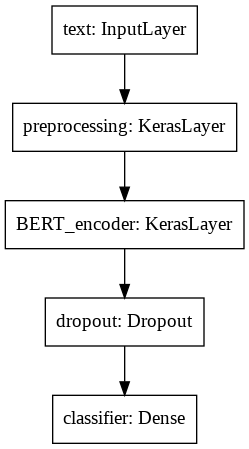

In [11]:
tf.keras.utils.plot_model(classifier_model)

In [12]:
! pip install -q tf-models-official
from official.nlp import optimization

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 100
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

In [15]:
print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es])

Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/100
2552/2552 [==============================] - 598s 229ms/step - loss: 1.2341 - sparse_categorical_accuracy: 0.6803 - val_loss: 0.8569 - val_sparse_categorical_accuracy: 0.7755
Epoch 2/100
2552/2552 [==============================] - 231s 90ms/step - loss: 1.0663 - sparse_categorical_accuracy: 0.7904 - val_loss: 1.0324 - val_sparse_categorical_accuracy: 0.7818
Epoch 3/100
2552/2552 [==============================] - 231s 91ms/step - loss: 0.8009 - sparse_categorical_accuracy: 0.8578 - val_loss: 1.5762 - val_sparse_categorical_accuracy: 0.7708
Epoch 4/100
2552/2552 [==============================] - 231s 91ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.9169 - val_loss: 1.8184 - val_sparse_categorical_accuracy: 0.7630
Epoch 00004: early stopping


In [16]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

60/60 [==============================] - 10s 138ms/step - loss: 1.3013 - sparse_categorical_accuracy: 0.8167
Loss: 1.3013056516647339
Accuracy: 0.8166666626930237


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


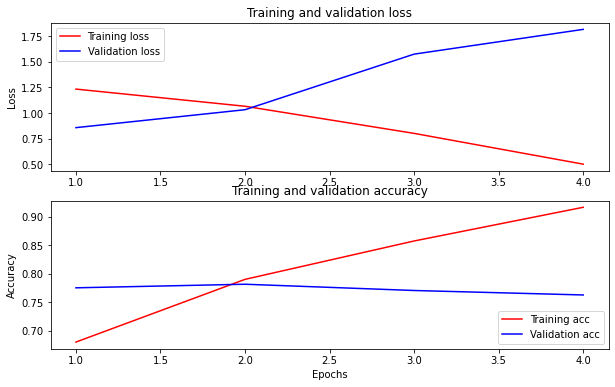

In [17]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [18]:
# from sklearn.model_selection import GridSearchCV

# params = {'epochs':[10,20,30], 'learning_rate':[2e-5, 3e-5, 5e-5]}
# grid = GridSearchCV(estimator=classifier_model, param_grid=params, scoring='sparse_categorical_accuracy', n_jobs=-1, cv=3)
# grid_result = grid.fit(X, Y)

# # fit gridsearch 
# clf.fit(X_train ,y_train)